# Ant Colony Optimization Algorithm

This notebook explains the Ant Colony Optimization Algorithm as applied to the Travelling Salesman Problem. 
- https://en.wikipedia.org/wiki/Ant_colony_optimization_algorithms 
- https://en.wikipedia.org/wiki/Travelling_salesman_problem


The Travelling Salesman Problem is a classic NP-hard problem and defined as:
> Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?

One possible solution is take inspiration from an Ant Colony and how it used decentralized intelligence to find food:
- the colony as a whole can be considered a single decentralized organism
  - evolutionarily speaking, the queen carries the genetic information for the entire colony
  - individual ants performing the same role as individual cells in a human body
- ants communicate using pheromones and leave a pheromone trail behind them as they walk
- when no food is found, scouts will randomly wander around looking for food
- when a scout finds food, it will carry it home and leave a pheromone trail signalling that there is food in this direction
- the scout will encourage worker ants to follow it back to the food
- the worker ants will generally follow the strongest pheromone trail, but sometimes randomly wander off it
- the worker ants will also leave a pheromone trail behind them, and the more ants that follow a path, the stronger that pheromone trail will become
- once a worker ant has found food, it will follow and strengthen the pheromone trail back home
- if an ant accidentally finds a shorter path, it's round trip times will be shorter than on longer path, more round-trips mean more pheromones
- as the pheromones along the shorter path build up faster than along the longer path, it will encourage more ants to explore this path, building up the pheromones even more quickly
- eventually the network of pheromone trails will map out near-optimal solutions for the shortest paths between food locations
- when the food runs out, the ants will disperse as scouts, and the old pheromone trails will fade away
- however, if the ants are not careful, they can all end up in a death spiral, all following each other in a circle but not going anywhere


The Ant Colony Optimization Algorithm can be extended using KMeans clustering, which provides an order of magnitude performance improvement for larger map sizes N=64 to N=512

# Map

First let us define a map of cities

In [8]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

united_states_map = mpimg.imread("./images/united_states_map.png")
def show_cities(path, w=12, h=8):
    """Plot a TSP path overlaid on a map of the US States & their capitals."""
    if isinstance(path, dict):      path = list(path.values())
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]    
    plt.imshow(united_states_map)    
    for x0, y0 in path:
        plt.plot(x0, y0, 'y*', markersize=15)  # y* = yellow star for starting point        
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])

    
def show_path(path, starting_city=None, w=12, h=8):
    """Plot a TSP path overlaid on a map of the US States & their capitals."""
    if isinstance(path, dict):      path = list(path.values())
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]
    
    starting_city = starting_city or path[0]
    x, y = list(zip(*path))
    #_, (x0, y0) = starting_city
    (x0, y0) = starting_city
    plt.imshow(united_states_map)
    #plt.plot(x0, y0, 'y*', markersize=15)  # y* = yellow star for starting point
    plt.plot(x + x[:1], y + y[:1])  # include the starting point at the end of path
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])
    
    
def polyfit_plot(x,y,deg, **kwargs):
    coefficients = np.polyfit(x,y,deg,**kwargs)
    poly  = np.poly1d(coefficients)
    new_x = np.linspace(x[0], x[-1])
    new_y = poly(new_x)
    plt.plot(x, y, "o", new_x, new_y)
    plt.xlim([x[0]-1, x[-1] + 1 ])
    
    terms = []
    for p, c in enumerate(reversed(coefficients)):
        term = str(round(c,1))
        if p == 1: term += 'x'
        if p >= 2: term += 'x^'+str(p)
        terms.append(term)        
    plt.title(" + ".join(reversed(terms)))    

In [9]:
def distance(xy1, xy2) -> float:
    if isinstance(xy1[0], str): xy1 = xy1[1]; xy2 = xy2[1];               # if xy1 == ("Name", (x,y))
    return math.sqrt( (xy1[0]-xy2[0])**2 + (xy1[1]-xy2[1])**2 )

def path_distance(path) -> int:
    if isinstance(path, dict):      path = list(path.values())            # if path == {"Name": (x,y)}
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]   # if path == ("Name", (x,y))
    return int(sum(
        [ distance(path[i],  path[i+1]) for i in range(len(path)-1) ]
      + [ distance(path[-1], path[0]) ]                                   # include cost of return journey
    ))

30


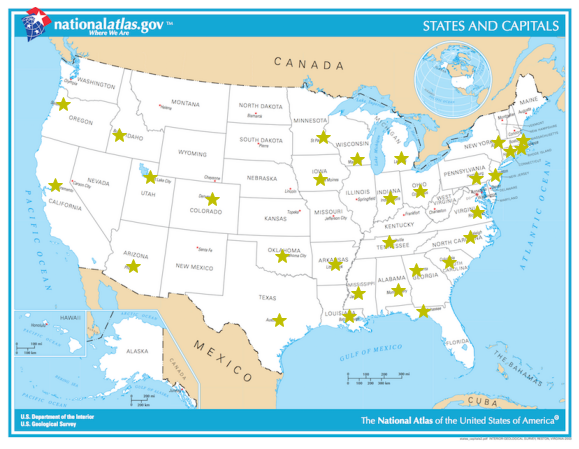

In [10]:
cities = { "Oklahoma City": (392.8, 356.4), "Montgomery": (559.6, 404.8), "Saint Paul": (451.6, 186.0), "Trenton": (698.8, 239.6), "Salt Lake City": (204.0, 243.2), "Columbus": (590.8, 263.2), "Austin": (389.2, 448.4), "Phoenix": (179.6, 371.2), "Hartford": (719.6, 205.2), "Baton Rouge": (489.6, 442.0), "Salem": (80.0, 139.2), "Little Rock": (469.2, 367.2), "Richmond": (673.2, 293.6), "Jackson": (501.6, 409.6), "Des Moines": (447.6, 246.0), "Lansing": (563.6, 216.4), "Denver": (293.6, 274.0), "Boise": (159.6, 182.8), "Raleigh": (662.0, 328.8), "Atlanta": (585.6, 376.8), "Madison": (500.8, 217.6), "Indianapolis": (548.0, 272.8), "Nashville": (546.4, 336.8), "Columbia": (632.4, 364.8), "Providence": (735.2, 201.2), "Boston": (738.4, 190.8), "Tallahassee": (594.8, 434.8), "Sacramento": (68.4, 254.0), "Albany": (702.0, 193.6), "Harrisburg": (670.8, 244.0) }
cities = list(sorted(cities.items()))
print(len(cities))
show_cities(cities)

7074

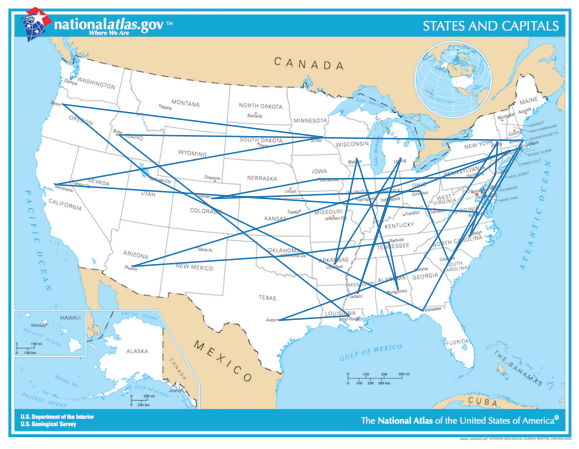

In [11]:
show_path(cities)
path_distance(cities)

# Meet the Ant Colony

- For performance reasons, the ants are represented as a set of 2048 wide numpy arrays, which allows for fast vectorized operations
- Many of the parameters are tunable, which will affect the internal logic of the ant colony, but have been set to sensible/optimal defaults
- The high-level logic of the algorithm is: 
    - we set the ants off on a random walk, each individually undertaking the quest of Travelling Saleman
        - `ant_count` defines the number of ants in the numpy array
        - `ant_speed` defines how many steps each ant travels per epoch
    - ants individually keep track of: 
        - `path` list of the cities they have previously visited
        - the set of `remaining` cities they still need to visit
        - `distance` to their next destination
        - `path_cost` of how many steps they have taken
        - the number of `round_trips` they have made to colony       
    - when the ants are travelling, there is a vectorized countdown of `distance`
    - when an ant arrives at a node:
        - it randomly selects a new destination on its remaining list
        - its choice is weighted by the amount pheromones left by other ants
        - `pheromone_power` affects the how strongly ants are affected by small differences in pheromones
        - `distance_power`  affects the awareness the ants have of distance, ie a preference to visit closer nodes first
        - `reward_power`    affects how `best_path/current_path` is used when laying new pheromones 
            - `** -3` was counterintuitively discovered as optimal
            - this encourages ants to explore longer paths around the strongest pheromones trail
        - `decay_power`     affects how quickly old pheromone trails decay
        - once an ant has visited all the nodes on its list, it returns home
    - once an ant returns home:
        - it updates the `self.pheromones` map for its completed path, telling the others that this way is popular
        - the pheromone reward increases with `self.round_trips` which has the effect of slowly decaying older pheromone trails
        - it updates the `self.ants_used` count    
        - it updates its individual `self.round_trips` count            
        - the ant resets and begins the Travelling Sales Problem again
    - if the ant has found a new best-yet path:
        - it informs the queen who keeps a record of the best path
        - the queen doubles the pheromones along this new best path, which doubles probability of ants exploring this path
        - `best_path_smell` controls the multipler the queen uses when a new best path is found 
    - Termination: there are several configurable options:
        - `self.stop_factor`   ant logic: if a new best path was found, then redouble efforts in search of a new best path before quitting
            - a factor of 2 will terminate in double the time required to find the last best path
            - a factor of 4 is more reliable in preventing early termination in some cases (but can be very time consuming)
        - `self.time`          run for a fixed number of seconds then stop
        - `self.min_time`      run for a minimum number of seconds before terminating naturally 
        - `self.timeout`       run for a maximum number of seconds but may terminate naturally beforehand
        - `self.round_trips`   wait for a minimum number of round_trips as a precondition to terminating (default 4)
        

In [12]:
import time
from itertools import chain
from typing import Any, Callable, List, Tuple, Union
import random



class AntColonySolver:
    def __init__(self,
                 cost_fn:                 Callable[[Any,Any], Union[float,int]],
                 time=0,                  # run for a fixed amount of time
                 min_time=0,              # minimum runtime
                 timeout=0,               # maximum time in seconds to run for
                 stop_factor=2,           # how many times to redouble effort after new new best path
                 min_round_trips=10,      # minimum number of round trips before stopping
                 max_round_trips=0,       # maximum number of round trips before stopping                 
                 min_ants=0,              # Total number of ants to use
                 max_ants=0,              # Total number of ants to use
                 
                 ant_count=64,            # this is the bottom of the near-optimal range for numpy performance
                 ant_speed=1,             # how many steps do ants travel per epoch

                 distance_power=1,        # power to which distance affects pheromones                 
                 pheromone_power=1.25,    # power to which differences in pheromones are noticed
                 decay_power=0,           # how fast do pheromones decay
                 reward_power=0,          # relative pheromone reward based on best_path_length/path_length 
                 best_path_smell=2,       # queen multiplier for pheromones upon finding a new best path                  
                 start_smell=0,           # amount of starting pheromones [0 defaults to `10**self.distance_power`]

                 verbose=False,

    ):
        assert callable(cost_fn)        
        self.cost_fn         = cost_fn
        self.time            = int(time)
        self.min_time        = int(min_time)
        self.timeout         = int(timeout)
        self.stop_factor     = float(stop_factor)
        self.min_round_trips = int(min_round_trips)
        self.max_round_trips = int(max_round_trips)
        self.min_ants        = int(min_ants)
        self.max_ants        = int(max_ants)
    
        self.ant_count       = int(ant_count)
        self.ant_speed       = int(ant_speed)
        
        self.distance_power  = float(distance_power)     
        self.pheromone_power = float(pheromone_power)
        self.decay_power     = float(decay_power)
        self.reward_power    = float(reward_power)
        self.best_path_smell = float(best_path_smell)
        self.start_smell     = float(start_smell or 10**self.distance_power)
        
        self.verbose         = int(verbose)
        self._initalized     = False
        
        if self.min_round_trips and self.max_round_trips: self.min_round_trips = min(self.min_round_trips, self.max_round_trips)
        if self.min_ants and self.max_ants:               self.min_ants        = min(self.min_ants, self.max_ants)


    def solve_initialize(
            self,
            problem_path: List[Any],
    ) -> None:
        ### Cache of distances between nodes
        self.distances = {
            source: {
                dest: self.cost_fn(source, dest)
                for dest in problem_path
            }
            for source in problem_path
        }

        ### Cache of distance costs between nodes - division in a tight loop is expensive
        self.distance_cost = {
            source: {
                dest: 1 / (1 + self.distances[source][dest]) ** self.distance_power
                for dest in problem_path
            }
            for source in problem_path
        }

        ### This stores the pheromone trail that slowly builds up
        self.pheromones = {
            source: {
                # Encourage the ants to start exploring in all directions and furthest nodes
                dest: self.start_smell
                for dest in problem_path
            }
            for source in problem_path
        }
        
        ### Sanitise input parameters
        if self.ant_count <= 0:
            self.ant_count = len(problem_path)
        if self.ant_speed <= 0:
            self.ant_speed = np.median(list(chain(*[ d.values() for d in self.distances.values() ]))) // 5
        self.ant_speed = int(max(1,self.ant_speed))
        
        ### Heuristic Exports
        self.ants_used   = 0
        self.epochs_used = 0
        self.round_trips = 0
        self._initalized = True        


    def solve(self,
              problem_path: List[Any],
              restart=False,
    ) -> List[Tuple[int,int]]:
        if restart or not self._initalized:
            self.solve_initialize(problem_path)

        ### Here come the ants!
        ants = {
            "distance":    np.zeros((self.ant_count,)).astype('int32'),
            "path":        [ [ problem_path[0] ]   for n in range(self.ant_count) ],
            "remaining":   [ set(problem_path[1:]) for n in range(self.ant_count) ],
            "path_cost":   np.zeros((self.ant_count,)).astype('int32'),
            "round_trips": np.zeros((self.ant_count,)).astype('int32'),
        }

        best_path       = None
        best_path_cost  = np.inf
        best_epochs     = []
        epoch           = 0
        time_start      = time.perf_counter()
        while True:
            epoch += 1

            ### Vectorized walking of ants
            # Small optimization here, testing against `> self.ant_speed` rather than `> 0` 
            #       avoids computing ants_arriving in the main part of this tight loop
            ants_travelling = (ants['distance'] > self.ant_speed)
            ants['distance'][ ants_travelling ] -= self.ant_speed
            if all(ants_travelling):
                continue  # skip termination checks until the next ant arrives
            
            ### Vectorized checking of ants arriving
            ants_arriving       = np.invert(ants_travelling)
            ants_arriving_index = np.where(ants_arriving)[0]
            for i in ants_arriving_index:

                ### ant has arrived at next_node
                this_node = ants['path'][i][-1]
                next_node = self.next_node(ants, i)
                ants['distance'][i]  = self.distances[ this_node ][ next_node ]
                ants['remaining'][i] = ants['remaining'][i] - {this_node}
                ants['path_cost'][i] = ants['path_cost'][i] + ants['distance'][i]
                ants['path'][i].append( next_node )

                ### ant has returned home to the colony
                if not ants['remaining'][i] and ants['path'][i][0] == ants['path'][i][-1]:
                    self.ants_used  += 1
                    self.round_trips = max(self.round_trips, ants["round_trips"][i] + 1)

                    ### We have found a new best path - inform the Queen
                    was_best_path = False
                    if ants['path_cost'][i] < best_path_cost:
                        was_best_path  = True
                        best_path_cost = ants['path_cost'][i]
                        best_path      = ants['path'][i]
                        best_epochs   += [ epoch ]
                        if self.verbose:
                            print({
                                "path_cost":   int(ants['path_cost'][i]),
                                "ants_used":   self.ants_used,
                                "epoch":       epoch,
                                "round_trips": ants['round_trips'][i] + 1,
                                "clock":       int(time.perf_counter() - time_start),
                            })

                    ### leave pheromone trail
                    # doing this only after ants arrive home improves initial exploration
                    #  * self.round_trips has the effect of decaying old pheromone trails
                    # ** self.reward_power = -3 has the effect of encouraging ants to explore longer routes
                    #                           in combination with doubling pheromone for best_path
                    reward = 1
                    if self.reward_power: reward *= ((best_path_cost / ants['path_cost'][i]) ** self.reward_power)
                    if self.decay_power:  reward *= (self.round_trips ** self.decay_power)
                    for path_index in range( len(ants['path'][i]) - 1 ):
                        this_node = ants['path'][i][path_index]
                        next_node = ants['path'][i][path_index+1]
                        self.pheromones[this_node][next_node] += reward
                        self.pheromones[next_node][this_node] += reward
                        if was_best_path:
                            # Queen orders to double the number of ants following this new best path                            
                            self.pheromones[this_node][next_node] *= self.best_path_smell
                            self.pheromones[next_node][this_node] *= self.best_path_smell


                    ### reset ant
                    ants["distance"][i]     = 0
                    ants["path"][i]         = [ problem_path[0] ]
                    ants["remaining"][i]    = set(problem_path[1:])
                    ants["path_cost"][i]    = 0
                    ants["round_trips"][i] += 1


            ### Do we terminate?
            
            # Always wait for at least 1 solutions (note: 2+ solutions are not guaranteed)
            if not len(best_epochs): continue 
            
            # Timer takes priority over other constraints
            if self.time or self.min_time or self.timeout:
                clock = time.perf_counter() - time_start
                if self.time:
                    if clock > self.time: break
                    else:                 continue
                if self.min_time and clock < self.min_time: continue
                if self.timeout  and clock > self.timeout:  break
            
            # First epoch only has start smell - question: how many epochs are required for a reasonable result?
            if self.min_round_trips and self.round_trips <  self.min_round_trips: continue        
            if self.max_round_trips and self.round_trips >= self.max_round_trips: break

            # This factor is most closely tied to computational power                
            if self.min_ants and self.ants_used <  self.min_ants: continue        
            if self.max_ants and self.ants_used >= self.max_ants: break            
            
            # Lets keep redoubling our efforts until we can't find anything more
            if self.stop_factor and epoch > (best_epochs[-1] * self.stop_factor): break
                                
            # Nothing else is stopping us: Queen orders the ants to continue!      
            if True: continue
            
            
            
        ### We have (hopefully) found a near-optimal path, report back to the Queen
        self.epochs_used = epoch
        self.round_trips = np.max(ants["round_trips"])
        return best_path


    def next_node(self, ants, index):
        this_node   = ants['path'][index][-1]

        weights     = []
        weights_sum = 0
        if not ants['remaining'][index]: return ants['path'][index][0]  # return home
        for next_node in ants['remaining'][index]:
            if next_node == this_node: continue
            reward = (
                    self.pheromones[this_node][next_node] ** self.pheromone_power
                    * self.distance_cost[this_node][next_node]  # Prefer shorter paths
            )
            weights.append( (reward, next_node) )
            weights_sum   += reward

        # Pick a random path in proportion to the weight of the pheromone
        rand = random.random() * weights_sum
        for (weight, next_node) in weights:
            if rand > weight: rand -= weight
            else:             break
        return next_node
            
        
def AntColonyRunner(cities, verbose=False, plot=False, label={}, algorithm=AntColonySolver, **kwargs):
    solver     = algorithm(cost_fn=distance, verbose=verbose, **kwargs)
    start_time = time.perf_counter()
    result     = solver.solve(cities)
    stop_time  = time.perf_counter()
    if label: kwargs = { **label, **kwargs }
        
    for key in ['verbose', 'plot', 'animate', 'label', 'min_time', 'max_time']:
        if key in kwargs: del kwargs[key]
    print("N={:<3d} | {:5.0f} -> {:4.0f} | {:4.0f}s | ants: {:5d} | trips: {:4d} | "
          .format(len(cities), path_distance(cities), path_distance(result), (stop_time - start_time), solver.ants_used, solver.round_trips)
          + " ".join([ f"{k}={v}" for k,v in kwargs.items() ])
    )
    if plot:
        show_path(result)
    return result

# Solving the Traveling Salesman Problem

The first round of ants quickly find a reasonable path, then the colony quickly converges on a near-optimal path
- There are 1024 ants travelling around at any one time
- The ants follow and create pheromones trail, but they also use a `1/distance` metric for determining the next city to go to
- Originally the ants used a `1/distance^2` heuristic, but after hyperparameter tuning, it was discovered that `1/distance` could produce equlivant results (and is now the default)
- The ants will keep redoubling their efforts until they can no longer find better best path 

{'path_cost': 4739, 'ants_used': 1, 'epoch': 4241, 'round_trips': 1, 'clock': 0}
{'path_cost': 4719, 'ants_used': 4, 'epoch': 4471, 'round_trips': 1, 'clock': 0}
{'path_cost': 4261, 'ants_used': 65, 'epoch': 8190, 'round_trips': 2, 'clock': 0}
{'path_cost': 3806, 'ants_used': 66, 'epoch': 8383, 'round_trips': 2, 'clock': 0}
{'path_cost': 3756, 'ants_used': 73, 'epoch': 8983, 'round_trips': 2, 'clock': 0}
{'path_cost': 3430, 'ants_used': 90, 'epoch': 9837, 'round_trips': 2, 'clock': 0}
{'path_cost': 3051, 'ants_used': 128, 'epoch': 11438, 'round_trips': 3, 'clock': 0}
{'path_cost': 2875, 'ants_used': 140, 'epoch': 12673, 'round_trips': 3, 'clock': 0}
{'path_cost': 2844, 'ants_used': 175, 'epoch': 13839, 'round_trips': 3, 'clock': 0}
{'path_cost': 2709, 'ants_used': 181, 'epoch': 14187, 'round_trips': 3, 'clock': 0}
{'path_cost': 2660, 'ants_used': 201, 'epoch': 15605, 'round_trips': 4, 'clock': 0}
{'path_cost': 2659, 'ants_used': 232, 'epoch': 16576, 'round_trips': 4, 'clock': 0}
{'path

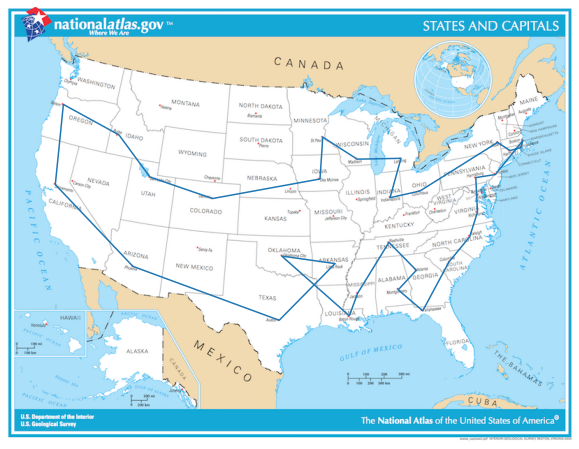

In [13]:
results = AntColonyRunner(cities, distance_power=1, verbose=True, plot=True)

# Solving with Wild Ants

Of course these ants are cheating. They can see the distances and have been taught to strongly squared prefer to visit closer nodes. In the wild, ants would be blind to everything except the pheromone trail, so lets see how this affects the algorithm.

- The ants slowly but methodically converge on better solutions
- The final path found is 30% longer than the distance^2 ants (2843 vs 2203)
- The first ant to return took a path almost double the length of the distance^2 ant (5906 vs 2987)
- The algorithm was alot more computationally expensive, with 6x runtime (94s vs 16s)
- The resultant graph contains more loops and sharp corners, as these represent the main paths found during early exploration 
- The path found, whilst not perfect, is still sufficently good to keep the wild ants from starving
- occasionally this suffers from early termination, so another termination condition is required `min_ants` to prevent this

{'path_cost': 5685, 'ants_used': 1, 'epoch': 5666, 'round_trips': 1, 'clock': 0}
N=30  |  7074 -> 5702 |    1s | ants:   577 | trips:   10 | distance_power=0 stop_factor=1.25


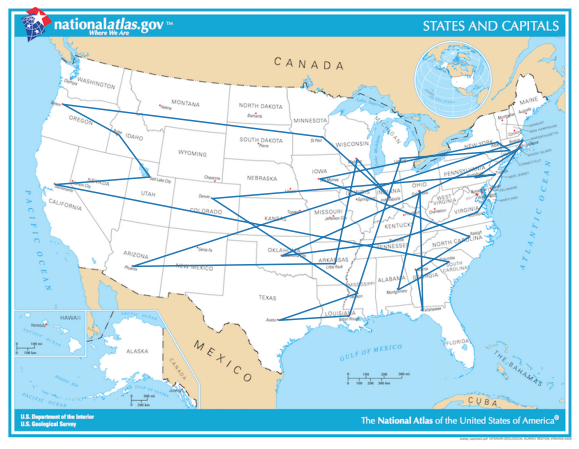

In [14]:
results = AntColonyRunner(cities, distance_power=0, stop_factor=1.25, verbose=True, plot=True)

Opps, we have suffered from early termination. Lets try to fix this:

{'path_cost': 5741, 'ants_used': 1, 'epoch': 5709, 'round_trips': 1, 'clock': 0}
{'path_cost': 5682, 'ants_used': 261, 'epoch': 34868, 'round_trips': 5, 'clock': 0}
{'path_cost': 5654, 'ants_used': 262, 'epoch': 34890, 'round_trips': 5, 'clock': 0}
{'path_cost': 5304, 'ants_used': 267, 'epoch': 35289, 'round_trips': 5, 'clock': 0}
{'path_cost': 5286, 'ants_used': 739, 'epoch': 84442, 'round_trips': 12, 'clock': 1}
{'path_cost': 5015, 'ants_used': 947, 'epoch': 105192, 'round_trips': 15, 'clock': 1}
{'path_cost': 4832, 'ants_used': 1192, 'epoch': 129073, 'round_trips': 19, 'clock': 1}
{'path_cost': 4784, 'ants_used': 1253, 'epoch': 134549, 'round_trips': 20, 'clock': 1}
{'path_cost': 4565, 'ants_used': 1290, 'epoch': 137669, 'round_trips': 20, 'clock': 2}
{'path_cost': 4399, 'ants_used': 1313, 'epoch': 139706, 'round_trips': 21, 'clock': 2}
{'path_cost': 4157, 'ants_used': 1332, 'epoch': 141480, 'round_trips': 22, 'clock': 2}
{'path_cost': 4147, 'ants_used': 1363, 'epoch': 143450, 'roun

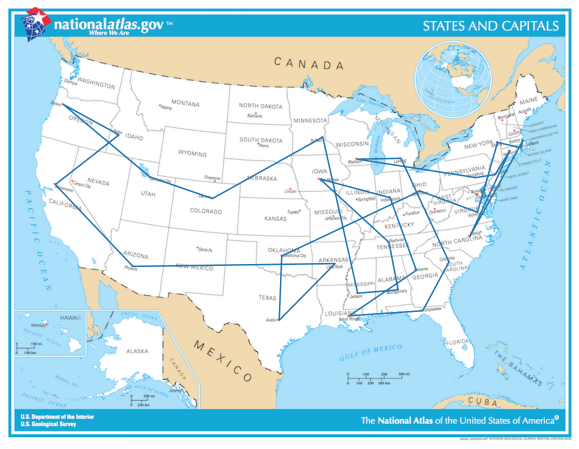

In [15]:
results = AntColonyRunner(cities, distance_power=0, min_time=30, verbose=True, plot=True)

# Statistical Random Variation

Whilst the Ant Colony Optimization Algorithm is not "complete" in the sense that it does not gaurentee to find the optimal path, it is able to quickly converge on a near-optimal path which may be acceptable for many usecases.

It contains a stochastic/random model, but a statistical analysis shows:


- For converged results:
  - standard deviation is 20.8 which is about 1% of the mean path length (2211.1) 
  - difference between maximum and minimum path length is 50 (2.5%)
  - average time to convergance is 47.2s
  
  
- Running on a fixed 10s timer:
  - standard deviation is reduced slightly to 17.3
  - average path length is only 20 (= 1%) higher than for converged results
  
This shows the algorithm is reasonably consistant and can be still produce acceptable results with early-termination. The law of deminishing returns applies to running the algorithm for extended periods of time.

In [16]:
results_converged = [ AntColonyRunner(cities) for i in range(10) ]

N=30  |  7074 -> 2271 |    2s | ants:  2082 | trips:   34 | 
N=30  |  7074 -> 2431 |    1s | ants:  1498 | trips:   24 | 
N=30  |  7074 -> 2239 |    2s | ants:  2612 | trips:   42 | 
N=30  |  7074 -> 2248 |    2s | ants:  2381 | trips:   38 | 
N=30  |  7074 -> 2301 |    3s | ants:  2864 | trips:   46 | 
N=30  |  7074 -> 2250 |    1s | ants:  1608 | trips:   26 | 
N=30  |  7074 -> 2334 |    1s | ants:  1033 | trips:   17 | 
N=30  |  7074 -> 2333 |    1s | ants:   673 | trips:   11 | 
N=30  |  7074 -> 2228 |    2s | ants:  1760 | trips:   28 | 
N=30  |  7074 -> 2248 |    3s | ants:  3400 | trips:   54 | 


In [17]:
results_timed = [ AntColonyRunner(cities, time=10) for i in range(10) ]

N=30  |  7074 -> 2201 |   10s | ants: 11923 | trips:  188 | time=10
N=30  |  7074 -> 2343 |   10s | ants: 12120 | trips:  190 | time=10
N=30  |  7074 -> 2213 |   10s | ants: 12205 | trips:  192 | time=10
N=30  |  7074 -> 2221 |   10s | ants: 12180 | trips:  191 | time=10
N=30  |  7074 -> 2341 |   10s | ants: 11571 | trips:  183 | time=10
N=30  |  7074 -> 2370 |   10s | ants: 11368 | trips:  179 | time=10
N=30  |  7074 -> 2357 |   10s | ants: 11900 | trips:  187 | time=10
N=30  |  7074 -> 2267 |   10s | ants: 11558 | trips:  183 | time=10
N=30  |  7074 -> 2294 |   10s | ants: 11900 | trips:  187 | time=10
N=30  |  7074 -> 2187 |   10s | ants: 12128 | trips:  191 | time=10


In [18]:
import pandas as pd
results_converged_stats = pd.Series([ path_distance(path) for path in results_converged ]).describe()
results_timed_stats     = pd.Series([ path_distance(path) for path in results_timed     ]).describe()
pd.DataFrame({
    "results_converged": results_converged_stats,
    "results_timed":     results_timed_stats,
    "difference":        results_converged_stats - results_timed_stats,
}).T.round(1)

,count,mean,std,min,25%,50%,75%,max
results_converged,10.0,2288.3,63.0,2228.0,2248.0,2260.5,2325.0,2431.0
results_timed,10.0,2279.4,70.7,2187.0,2215.0,2280.5,2342.5,2370.0
difference,0.0,8.9,-7.7,41.0,33.0,-20.0,-17.5,61.0


# Hyperparameter Optimization

There are a number of hyperparameters that can be tuned:
```
- ant_count=2048,          # this is close to the optimal number for performance
- ant_speed=1,             # how many steps do ants travel per epoch
- start_smell=0,           # amount of starting pheromones [0 defaults to `10**self.distance_power`]
- best_path_smell=2,       # queen multiplier for pheromones upon finding a new best path 
- reward_power=-3,         # Counter intuatively -3 actually rewards longer paths, but leads to more exploration
- distance_power=2,        # power to which distance affects pheromones
- pheromone_power=1,       # power to which differences in pheromones are noticed
- decay_power=1,           # how fast do pheromones decay
```

# ant_count

This really shows the performance impact of using vectorized numpy arrays vs python loops
- observe the number of ants generated
- operations on numpy arrays have a linear overhead
- using very small arrays (4 or smaller) can be much slower than using python primitives
- 256-4096 is the sweet spot for the optimal size of numpy arrays in a tight loop
- 64-16384 still provides near optimal performance
- 32768+ results in a dramatic drop in performance - as bad as using very small arrays 

In [ ]:
for ant_count in range(0,16+1):
    AntColonyRunner(cities, ant_count=2**ant_count, time=60)

N=30  |  7074 -> 2309 |   60s | ants:  5264 | trips: 5264 | ant_count=1 time=60
N=30  |  7074 -> 2557 |   60s | ants:  9954 | trips: 4978 | ant_count=2 time=60
N=30  |  7074 -> 2601 |   60s | ants: 16063 | trips: 4018 | ant_count=4 time=60


KeyboardInterrupt: 

# min_ants

One of the main unsolved problem is how to optimize the performance of the algorithm whilst also correctly detecting convergance 

- a low ant_count will mean more round trips per second
    - this will make better use of the pheromone trail
    - this also increases the risk of early termination 
- a too high ant count
    - will avoid early termination
    - but result is only a small number of round trips
    - this also affects the relative strength of the start_smell
- algorithm phases
    - early on, there can be very large 4x-10x gaps before finding a new best path
    - during the middle of the algorithm, new best paths will be regularly found withn 1.1x - 1.5x
    - at the end of the algorithm, the ants will search for a long time without finding anything new
    - but occasionally randomly find a slightly better new best path, which resets the 2x timer
    - unsure exactly how to set a stop_factor that accounts for all of this
- ant_count
    - to few ants and the pheromone trail doesn't get built up fast enough, the ants 
- the current algorithm cheats quite a bit by using a distance heuristic, which is doing half the work

In [ ]:
for N in range(8,30+1):
    best = { "ant_count": 0, "min_ants": 0, "path": None, "count": 0 }
    for ant_count in [8,16,32,64,128,256,512,1024,2048]:
        for min_ants in [64,128,256,512,1024,2048,4096,8192]:
            result = AntColonySolver(ant_count=ant_count, min_ants=min_ants, cost_fn=distance).solve(cities[:N])
            if not best['path'] or best['path'] > path_distance(result):
                best = { "ant_count": ant_count, "min_ants": min_ants, "path": path_distance(result), "count": best['count']+1 }
                continue
            if best['count'] >= 3: 
                best['count'] = 0
                break
    AntColonyRunner(cities[:N], ant_count=best['ant_count'], min_ants=best['min_ants'])

# ant_speed

Increasing `ant_speed` affects the number of steps taken per epoch loop
- This doesn't have much effect on the mechanics of the underlying algroythem
- It provides a small performance optimization, as it reduces the number of epoch loops
    - The effect of `ant_speed` is much more noticable when not using numpy vectorization
    - The numpy implemention defaults to `1` for algorithm fidelity
- If `ant_speed` is set too high, then the ants effectively jump from city to city without any travel time
    - This slightly distorts the algorithm in theory, but the effect on path costs is within noise levels for statistical variation
- Setting `ant_speed=0` attempts an auto-optimized value of: `median distance between nodes // 5`

In [ ]:
for ant_speed in list(range(0,10+1)):
    result = AntColonyRunner(cities, ant_speed=2**ant_speed, time=10)
result = AntColonyRunner(cities, ant_speed=0, time=10)    

# distance_power

As documented in the introduction, this affects the ability of ant to see distance when choosing a next node, rather than just blindly smelling the pheromone trail. This can have a big impact on performance and runtimes.

- `-1` or negative distance powers encourage ants to travel to more distant nodes first. 
    - This finds is worse than random results
    - Ants may or may not find a better solution than the first ant to return home
- `0` this disables the distance metric and rely purely on the pheromones trail (like wild ants)
    - this can be very slow to converge 
    - can occasionally run into early termination issues (not finding new best paths quick enough)
- `1` this works perfectly well, but graphs can contain tangled loops around clusters of closely spaced nodes
- `1.5 - 2.0` this converges much more quickly and produces cleaner, more circular graphs (default = 2)
- `3+` this converges a little too quickly, with less exploration, and finds suboptimal routes
- `10` this is a cheat solution, slightly suboptimal, but converges very quickly based on distance alone

In [ ]:
for distance_power in [-2.0, -1.0, 0.0, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 3.0, 5.0, 10.0]:
    result = AntColonyRunner(cities, distance_power=distance_power, timeout=60)

# pheromone_power
This affects the power to which relative differences in pheromones are noticed. 

- Negative numbers make the pheromones repulsive, yet the algorithm still finds (slightly) better than random results
- The pheromone_power effect is most noticable when the distance heuristic is disabled.
- When run without a timer, increasing a tiny bit above 1 resulted in a massive path_length improvement with a significantly extended runtime. 
    - The sweet spot seems to be around `1.25` (setting this to default)
    - This shows an amplified sensitivity to pheromones and that the ants could continually find new paths
    - This also seems to amplify the effect of other smell heuristic settings[[](http://)](http://)
- Setting `pheromone_power` destroys the fine balance between optimization and exploration

In [ ]:
for distance_power in [0,1,2]:
    for pheromone_power in [-2.0, -1.0, 0.0, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 3.0, 5.0, 10.0]:
        result = AntColonyRunner(cities, distance_power=distance_power, pheromone_power=pheromone_power, time=0)
    print()

In [ ]:
for distance_power in [0,1,2]:
    for pheromone_power in [1.0, 1.1, 1.2, 1.3, 1.4]:
        result = AntColonyRunner(cities, distance_power=distance_power, pheromone_power=pheromone_power, time=0)
    print()

# decay_power

how fast do pheromones decay

```
reward = (self.round_trips ** self.decay_power) * ((best_path_cost / ants['path_cost'][i]) ** self.reward_power)
```

- with `pheromone_power=1.0` 
    - the effect seems almost indistingusable from noise
    
    
- with `pheromone_power=1.25`
    - There is still lots of variation when rerunning the results    
    - with `distance_power=0`: `0` is the sweet spot
    - with `distance_power=1`: `0`-`1.25` is the sweet spot
    - with `distance_power=2`: 
         - previous sweet spots: `0`, `1.25`, `2`
         - results now indistingusable from noise
         
 Setting default to: `0`

In [ ]:
for pheromone_power in [1.0, 1.25]:
    for distance_power in [0,1,2]:
        for decay_power in [-1.0, 0.0, 1.0, 1.25, 1.5, 2.0, 3.0]:
            result = AntColonyRunner(cities, pheromone_power=pheromone_power, distance_power=distance_power, decay_power=decay_power, time=15)
        print()
    print()

In [ ]:
for distance_power in [0,1,2]:
    for decay_power in [-2.0, -1.0, 0.0, 0.5, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0, 10.0]:
        result = AntColonyRunner(cities, distance_power=distance_power, decay_power=decay_power, time=0)
    print()

# reward_power
```
reward = (self.round_trips ** self.decay_power) * ((best_path_cost / ants['path_cost'][i]) ** self.reward_power)
```

This is the pheromone reward given by each ant after it makes a round trip, and is relative to the path_cost of the route it took
- Numbers are normalized to be very close to 1
- Negative powers increase the relative reward for longer path lengths
- Negative powers increase the relative reward for shorter path lengths


It doesn't have a effect much larger than the statistical noise (std = 20). 

- For `best_path_smell=1`: 
    - The effects of reward_power are more amplified when `best_path_smell` is disabled
    - `-1` or `-2` produces a produces a small but noticable effect
    - `-2` caused an exceptionally long runtime without a timeout (ants kept continually finding new best paths)
    - `4+` results in a noticable deoptimization


- For `best_path_smell=2`: 
    - Previous experiments (and current default) suggsted `-3` was the optimal setting, but I have been unable to reproduce this here
    - disabling this feature and setting `reward_power=0` actually produces the best results here
    
Update: changing the default back to 0

In [ ]:
for decay_power in [-2.0, -1.0, 0.0, 0.5, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0, 10.0]:
    result = AntColonyRunner(cities, decay_power=decay_power, timeout=60)
    print()

In [ ]:
for decay_power in [-2.0, -1.0, 0.0, 0.5, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0, 10.0]:
    for reward_power in range(-5,5+1):
        result = AntColonyRunner(cities, decay_power=decay_power, reward_power=reward_power, time=15)
    print()

# best_path_smell

This is the reward given by the queen for finding a new best path and encourages more ants to explore around this new route

- This has less effect on short runtimes
- `best_path_smell == -1` 
    - with `pheromone_power=1`:     causes ants to go in random directions when then encounter negative pheromones
    - with `pheromone_power=1.25`:  throws an exception due to comparing: float > complex √-1 numbers 
- `best_path_smell < 1` effectively tells the ants to stop exploring the best path. This converges quickly on a poor score.
- `best_path_smell == 1` removes this functionality, the ants still find a reasonable path
- `best_path_smell > 1` improves the ability for ants to continually find better paths, and not give up so quickly
    - it doesn't need to be much above 1 for it to work (the ants all follow each other, creating a feedback loop)
    - higher values don't produce any additional effect
    - setting it very high (5+) undoes this effect as prevents the ants from exploring neighbouring routes
- `best_path_smell > 2` 
    - is required for this heuristic to be most effective at `distance_power=0` 
    - still works just as well for `distance_power=1` or `distance_power=2`  
    - the default value is `2`

In [ ]:
for distance_power in [0,1,2]:
    for best_path_smell in [0.0, 0.5, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0, 10.0]:
        result = AntColonyRunner(cities, distance_power=distance_power, best_path_smell=best_path_smell, time=15)
    print()

In [ ]:
for distance_power in [0,1,2]:
    for best_path_smell in [0.0, 0.5, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0, 10.0]:
        result = AntColonyRunner(cities, distance_power=distance_power, best_path_smell=best_path_smell, min_round_trips=20, time=0)
    print()

# start_smell

This affects the amount of pheromones on the map at the start of the search. High values encourage more randomness in early exploration.
- The effects of this are more noticable with a lower `self.distance_power`
- If the `start_smell` is too low, the ants quickly converge on the first non-optimal path, then take longer to correct themselves
- If the `start_smell` is too high, then it will take a long time for the pheromones left by the ants to overpower the `start_smell`
    - This can also distort the pheromones trail left by randomly wandering ants, leading to suboptimal paths
- If the `start_smell` is very high, then this completely overpowers the pheromone map, leaving the ants to rely on the distance metric alone
- If the `start_smell` is just right, the ants will have a good balance between optimization and exploration and quickly converge
- `start_smell=0` defaults to `10**self.distance_power`


In [ ]:
for distance_power in [0, 1, 2]:
    for start_smell in list(range(0,8)):
        result = AntColonyRunner(cities, distance_power=distance_power, start_smell=10**start_smell, time=15)
    result = AntColonyRunner(cities, distance_power=distance_power, start_smell=0, time=15)
    print()

# stop_factor

This controls how many times the ants will redouble their efforts after finding a new best path before giving up.

- The tradeoff is the risk of early termination vs excessive runtimes with the law of diminishing returns for better paths
- `1.5` is too small and often results in early termination 
- `2` seems to be about the right factor for reaching convergance
- `5+` burns CPU cycles without generating any significantly better solutions

In [ ]:
for distance_power in [0, 1, 2]:
    for stop_factor in [1.25, 1.5, 1.75, 2, 5]:
        result = AntColonyRunner(cities, distance_power=distance_power, stop_factor=stop_factor)
    print()

# NP Hard Scalability

So the Ant Colony Optimization Algorithm works fairly well on small maps of size 30 nodes, but how does it scale against larger problems?

First let us create a new map with random coordinates

In [ ]:
import string
def create_cities(size, max_x=1000, max_y=1000, image=None, color=1, border=30):
    if (image is not None):
        max_x = image.shape[0] - 1 - border*2
        max_y = image.shape[1] - 1 - border*2
    cities = {}
    while len(cities) <= size:
        name = ''.join(random.choices(string.ascii_lowercase, k=10))
        x = round( border + random.random() * max_x,  1)
        y = round( border + random.random() * max_y,  1)
        if (image is not None) and not all( image[int(x)][int(y)] == color ): continue
        cities[(int(x),int(y))] = ( name, (y,x) )               
    return list(cities.values())

np_hard = create_cities(256, image=united_states_map)
print(np_hard[:5])
show_cities(np_hard)

First let look at some of the smaller problems
- For the smallest problems `N<8` most of the time is spent just marching 1024 ants for a minimum of 4 round trips
- Running to convergance takes exponentally longer for each doubling of the problem size
- The ants can still find a reasonable path for N=64

In [ ]:
for N in [8,16,32,64,128,256]:
    result = AntColonyRunner(np_hard[:N], label={ "N": N }, timeout=60*60)
    plt.figure()
    plt.title(f'N={N}')        
    show_path(result)    
print()

Lets limit time complexity to N^2

In [ ]:
for N in [8,16,32,64,128,256]:
    result = AntColonyRunner(np_hard[:N], label={ "N": N }, max_ants=N**2, timeout=60*60)
    plt.figure()
    plt.title(f'N={N}')    
    show_path(result)        
print()

What if we enable cheat mode with `distance_power=10`
- Thus works quicker and faster than relying on the pheromone trail
- Even with an N^2 limitation on the ants, there is still an 14 minute runtime on N=256

In [ ]:
for N in [8,16,32,64,128,256]:
    result = AntColonyRunner(np_hard[:N], label={ "N": N }, distance_power=10, max_ants=N**2, timeout=60*60)
    plt.figure()
    plt.title(f'N={N}')
    show_path(result)            
print()